In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
import emcee
import sys

In [3]:
from maystats import *


gp_list = []

def build_GP( params, ell, ps_mean, 
             PS_scale = 1e-9 ):
    global gp_list
    gp_list = []
    for test_ell_bin in range(len(ell)):
        X = np.array([table['M_nu(eV)'], 
                      table['Omega_m'], 
                      table['10^9*A_s']])
        X = np.atleast_2d(X).T
        y = np.array([np.mean(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
        dy = np.array([sem(ps_temp,axis=0)[test_ell_bin] for ps_temp in ps_mean]) / PS_scale
        kernel =  C( 1.0, (1e-3, 1e3))  * RBF( np.ones(3), (1e-5, 1e5))
        gp = GaussianProcessRegressor(kernel=kernel, 
                                      alpha=(dy)**2, 
                                      n_restarts_optimizer=10,
                                      normalize_y=True)
        gp.fit(X, y)
        gp_list.append(gp)

    def get_PS_( x ):
        y_pred_list = []
        sigma_list = []
        for gp in gp_list:
            y_pred, sigma = gp.predict( np.atleast_2d(x), return_std=True)
            y_pred_list.append(y_pred[0])
            sigma_list.append(sigma[0])

        return np.array(y_pred_list), np.array(sigma_list)
    
    return get_PS_

In [4]:
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['10^9*A_s']])

ell = []
ps_real = []
redshifts = ['10']
for redshift in redshifts:
    ell_, ps_real_ = get_real_list( 'PS', noisy='KN', redshift=redshift,  
                                   bin_min=300, bin_max=3000, smoothing='1.00', binscale='log' )
    ell.append(ell_)
    ps_real.append(ps_real_)
    
ell = np.hstack(ell)
ps_real = np.dstack(ps_real)
    
invcov = 1e-18*get_invcov( 'PS', noisy='KN', redshifts=redshifts, 
                                   bin_min=300, bin_max=3000, smoothing='1.00', binscale='log')
fid = np.mean( ps_real[1], axis=0 ) * 1e9
get_PS = build_GP( params, ell, ps_real )

nr 9999 nb 20 bin 0.9978995799159832 sky 0.001225


In [17]:
m_nu_min = np.min(table['M_nu(eV)'])
m_nu_max = np.max(table['M_nu(eV)'])
om_m_min = np.min(table['Omega_m'])
om_m_max = np.max(table['Omega_m'])
A_s_min =  np.min(table['10^9*A_s'])
A_s_max =  np.max(table['10^9*A_s'])


def lnprior(theta):
    m_nu, om_m, A_s = theta
    if m_nu_min < m_nu < m_nu_max and om_m_min < om_m < om_m_max and A_s_min < A_s < A_s_max:
        return 0.0
    return -np.inf

def lnlike(theta):
    model, sig = get_PS( theta )
    dmu = fid - model
    return -0.5*( np.dot( dmu, np.dot( invcov, dmu) ) )

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

lnprob([0.1, 0.3, 2.1])

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


-0.5244430248713756

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


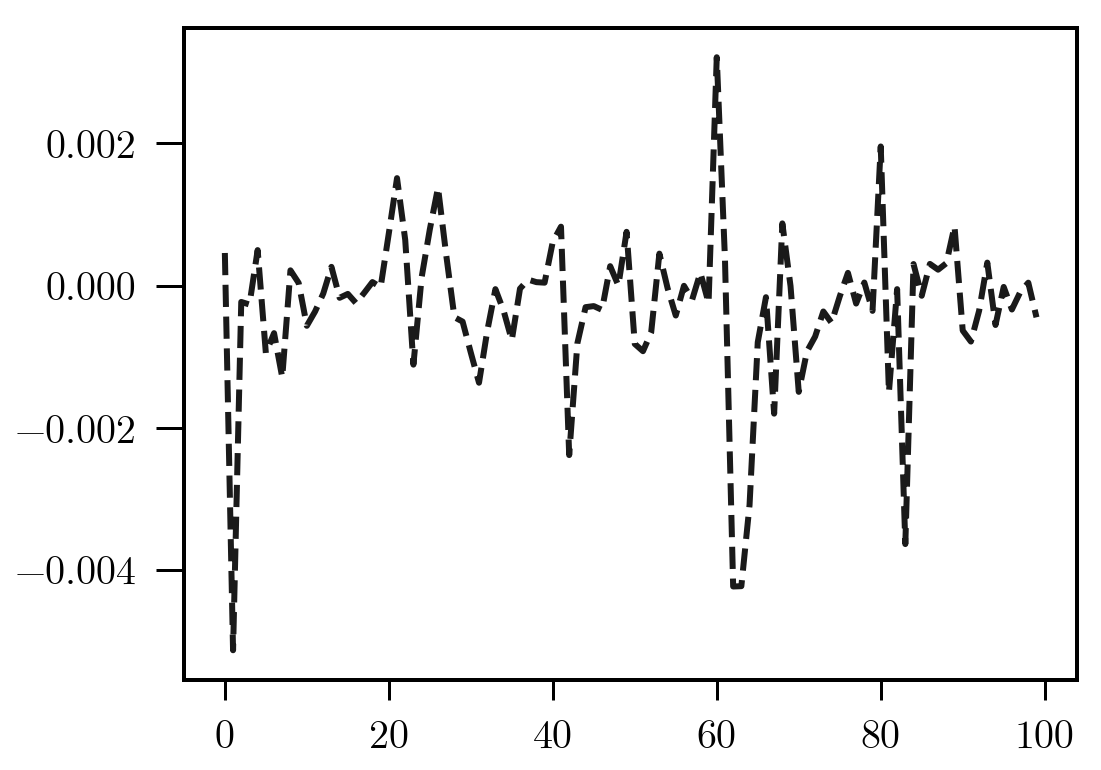

In [18]:
# plt.plot(fid)
ys, sigs = get_PS( params.T[1] )
plt.plot( (ys - fid)/fid, '--')

In [37]:
lnprob( [0.1, 0.3, 2.1] )

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


-3.180053605951333

In [44]:
model, sig = get_PS( [0.1, 0.3, 2.1] )
dmu = fid - model
-0.5*( np.dot( dmu, np.dot( invcov, dmu) ) )

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


-3.180053605951333

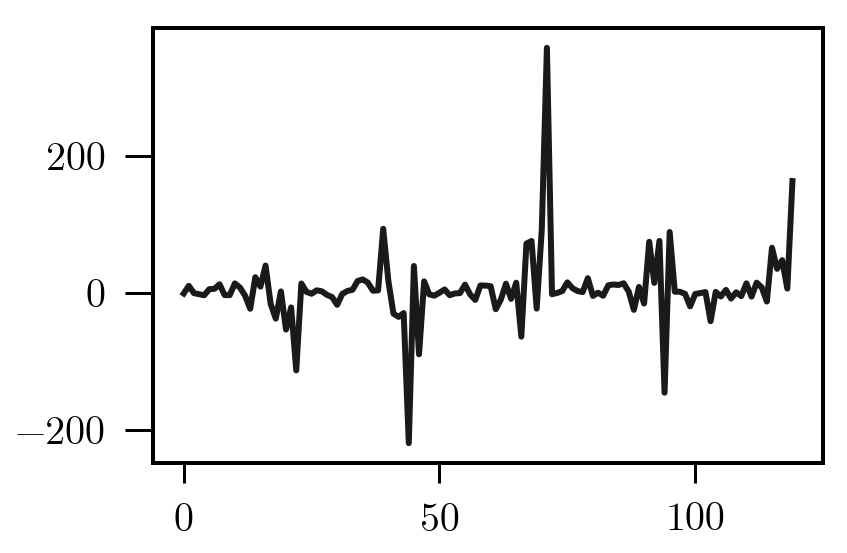

In [53]:
plt.plot( np.dot( invcov, dmu) )

In [6]:
ndim, nwalkers = 3, 128
p0 = [ params.T[1] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [ ]:
%%time

nsteps = 500
width = 30
for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
    n = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


[####                          ]

In [ ]:
plt.plot( sampler.chain[0,:,0])
plt.plot( sampler.chain[1,:,0])

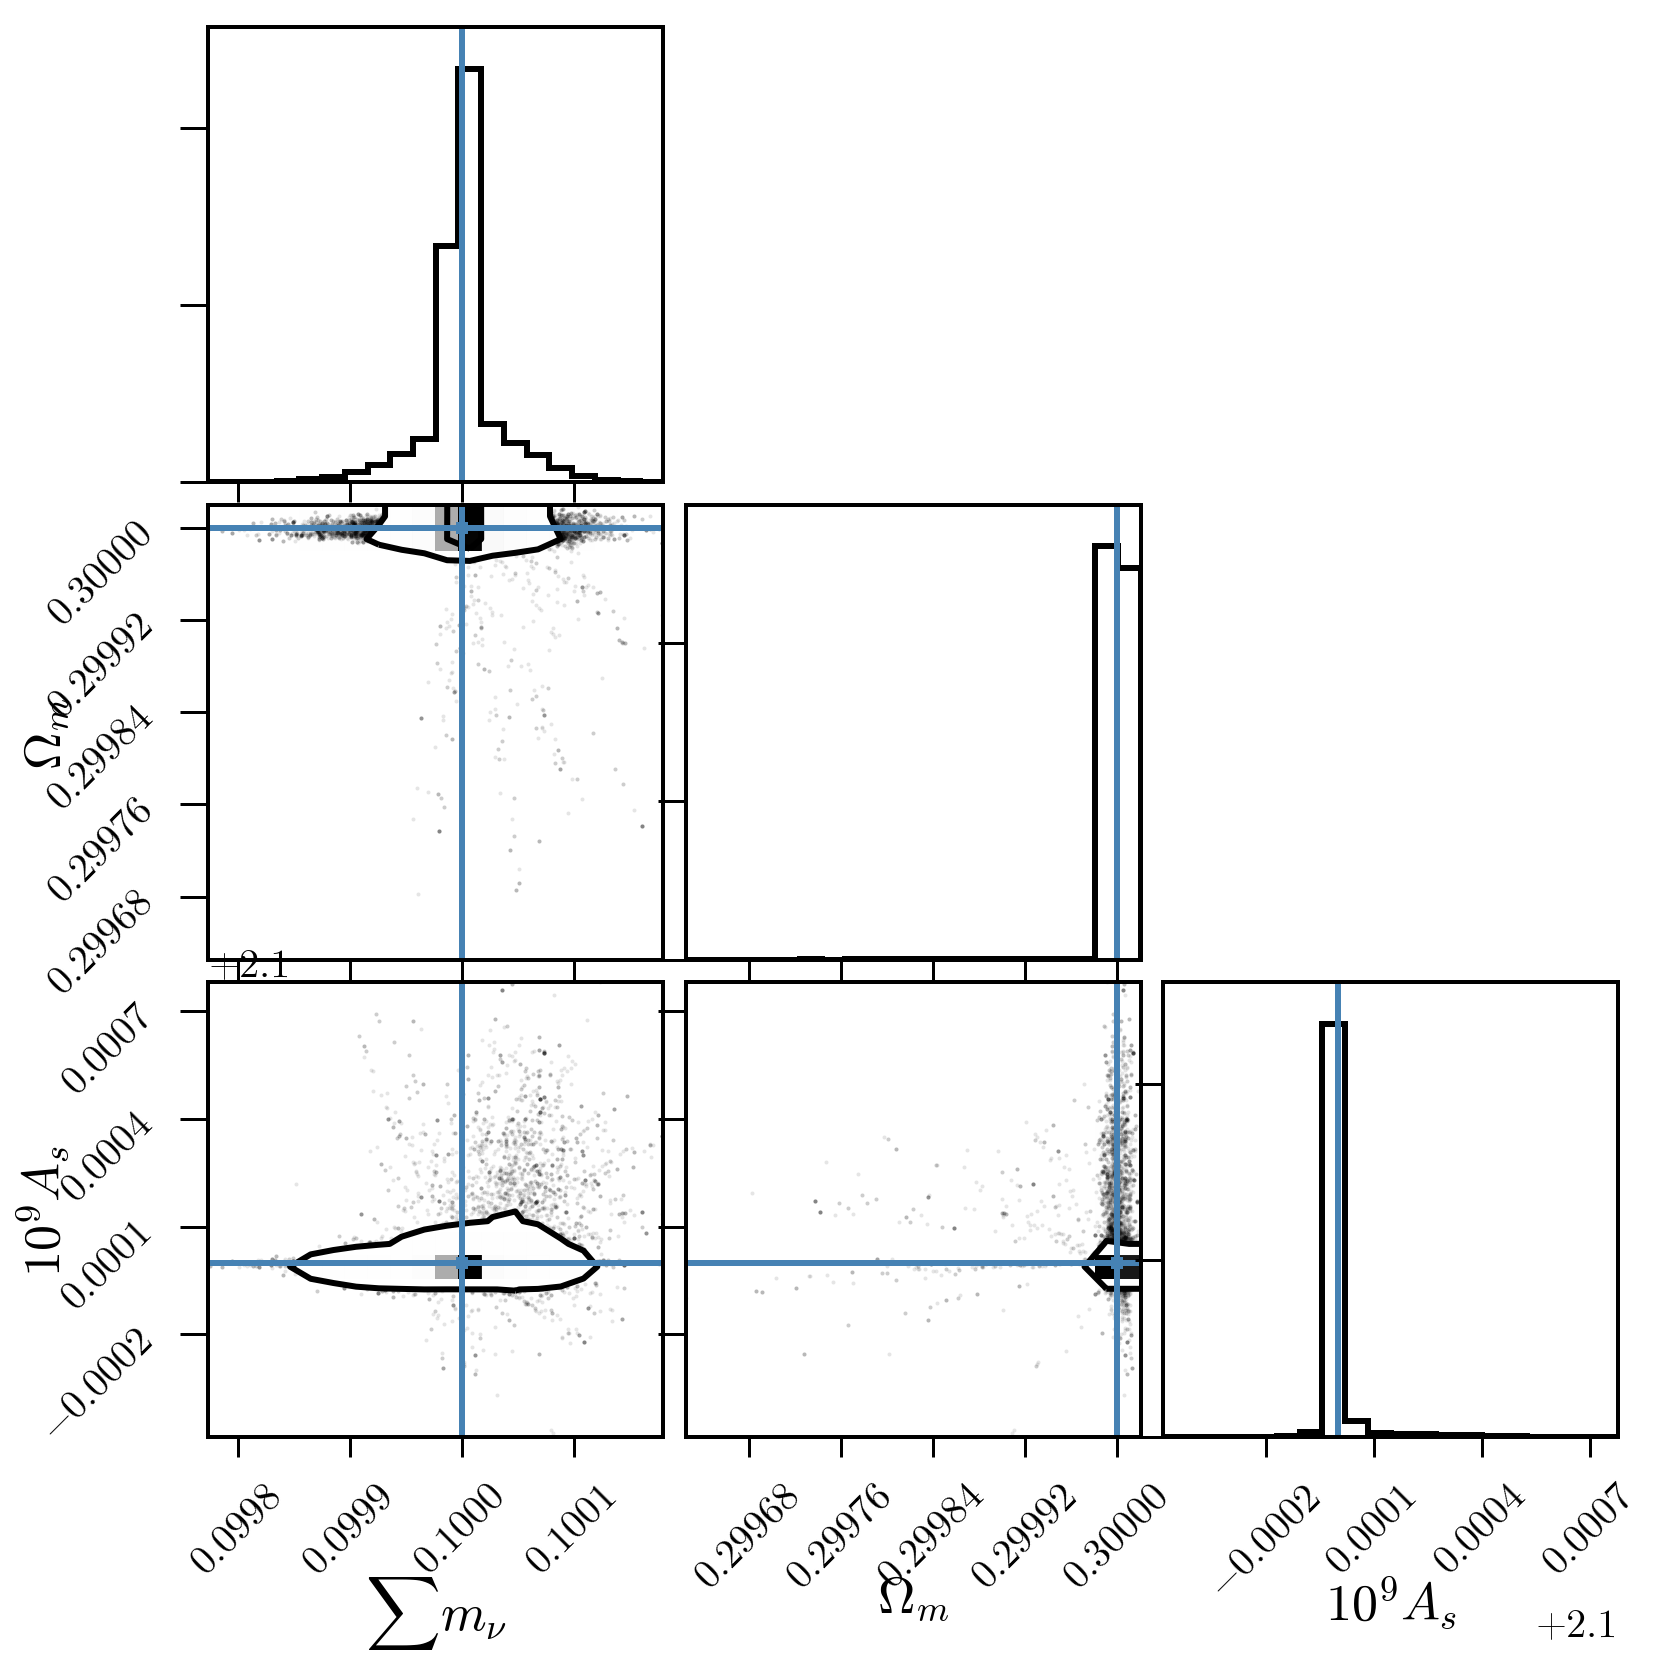

In [20]:
import corner
fig, axes = plt.subplots(3,3, figsize=(12,12))
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=[r"$\sum m_{\nu}$", r"$\Omega_m$", r"$10^9 A_s$"],
                      truths=params.T[1], fig=fig, levels=(0.68, 0.95))

In [31]:
f = open("chain.dat", "w")
f.close()

for result in sampler.sample(p0, iterations=500, storechain=False):
    position = result[0]
    f = open("chain.dat", "a")
    for k in range(position.shape[0]):
        f.write("{0:4d} {1:s}\n".format(k, ' '.join(map(str, position[k]))))
    f.close()

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


emcee: Exception while calling your likelihood function:
  params: [0.10034244 0.30001059 2.1004494 ]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/zequnl/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-9-439147be424e>", line 17, in lnprob
    return lp + lnlike(theta)
  File "<ipython-input-9-439147be424e>", line 9, in lnlike
    model, sig = get_PS( theta )
  File "<ipython-input-12-1c7346efc18b>", line 27, in get_PS_
    y_pred, sigma = gp.predict( np.atleast_2d(x), return_std=True)
  File "/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py", line 325, in predict
    L_inv = solve_triangular(self.L_.T, np.eye(self.L_.shape[0]))
  File "/home/zequnl/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 348, in solve_triangular
    trans=trans, unitdiag=unit_diagonal)
KeyboardInterrupt


KeyboardInterrupt: 